In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import convolve2d, fftconvolve

In [3]:
# 创建图像尺寸
width = 256
height = 256
collect_number = 800

# 生成坐标网格
x = np.arange(width) - (width-1)/2.0
y = (height-1)/2.0 - np.arange(height)
x, y = np.meshgrid(x, y)


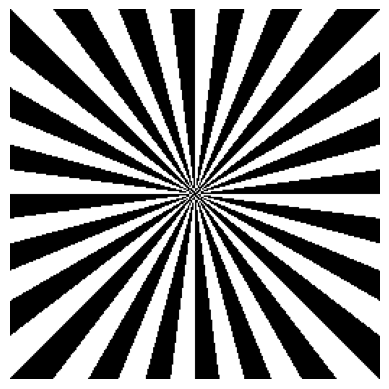

In [4]:
# 计算极角（角度制）
theta = np.degrees(np.arctan2(y, x))
theta = np.mod(theta + 360, 360)  # 转换为0-360度

# 计算扇形区域（48个辐条）
num_spokes = 48
sector_size = 360 / num_spokes
sectors = np.floor(theta / sector_size)

image_array = np.where(np.mod(sectors, 2) == 0, 0, 1)
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

# 存储为8位灰度图像tiff格式
image = Image.fromarray(np.uint8(image_array*255))
image.save('sector_image.tif')

In [5]:
'''
# 生成256x256的随机散斑图片
speckle_images = np.zeros((collect_number, height, width))
for i in range(collect_number):
    speckle_image = np.zeros((height, width))
    num_speckles = 1000
    indices = np.random.choice(height * width, num_speckles, replace=False)
    speckle_image[np.unravel_index(indices, (height, width))] = 1
    speckle_images[i, :, :] = speckle_image

plt.imshow(speckle_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()
del indices, speckle_image
'''
del x, y, theta, sectors, num_spokes, sector_size

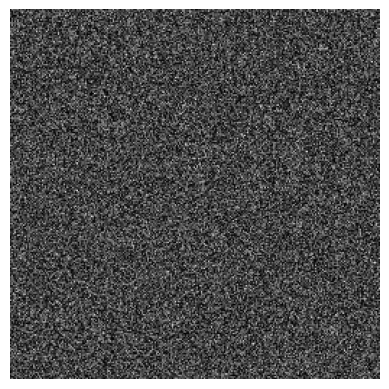

In [6]:
# 生成256x256的随机散斑图片，像素值呈现半正态分布，平均值为0.3，方差为0.2
speckle_images = np.abs(np.random.normal(0.3, 0.2, (collect_number, height, width)))
speckle_image = speckle_images[400, :, :]

# 显示其中一张随机散斑图片
plt.imshow(speckle_image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()


# 存储为8位灰度图像tiff格式
# image = Image.fromarray(np.uint8(speckle_images[400, :, :]*255))
# image.save('speckle.tif')

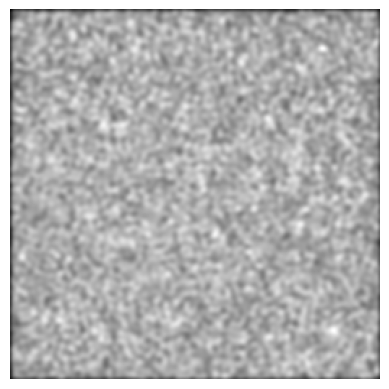

In [11]:
# 加载 PSF 图像
psf_405nm_image = Image.open('PSF256_405nm.tif')
psf_405nm_array = np.array(psf_405nm_image)

# 对散斑图片进行卷积
convolved_speckle_images = np.zeros((collect_number, height, width))
speckle_image = np.zeros((height, width))
convolved_speckle_image = np.zeros((height, width))

for i in range(collect_number):
    speckle_image = speckle_images[i, :, :]
    #convolved_speckle_image = fft2(fftshift(speckle_image)) * fft2(fftshift(psf_405nm_array))
    #convolved_speckle_image = ifftshift(ifft2(convolved_speckle_image).real)
    convolved_speckle_image = fftconvolve(speckle_image, psf_405nm_array, mode='same')
    convolved_speckle_images[i, :, :] = convolved_speckle_image

# 显示卷积后的图像
plt.imshow(convolved_speckle_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

# 存储为8位灰度图像tiff格式
image = Image.fromarray(np.uint8(convolved_speckle_images[400, :, :]*25.5))
image.save('speckle_convolve.tif')


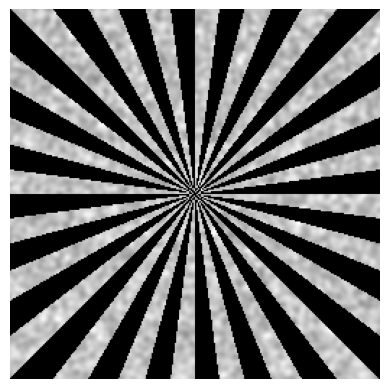

In [ ]:
# 将 convolved_speckle_image 和 image_array 进行点乘
illuminate_images = np.zeros((collect_number, height, width))

for i in range(collect_number):
    convolved_speckle_image = convolved_speckle_images[i, :, :]
    illuminate_image = convolved_speckle_image * image_array
    illuminate_images[i, :, :] = illuminate_image

# 展示结果图像
plt.imshow(illuminate_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

# 存储为8位灰度图像tiff格式`    `
image = Image.fromarray(np.uint8(illuminate_images[400, :, :]*255))
image.save('sample_illu.tif')

# del convolved_speckle_image, illuminate_image

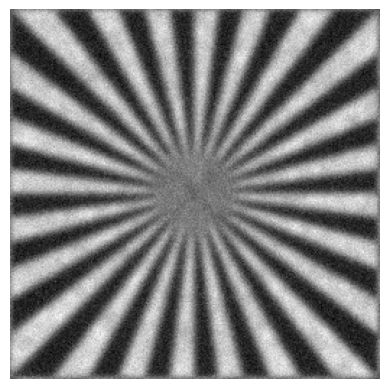

In [ ]:
# 加载 PSF 图像
psf_520nm_image = Image.open('PSF256_520nm.tif')
psf_520nm_array = np.array(psf_520nm_image)
collect_images = np.zeros((collect_number, height, width))

# 对卷积后的图片加上泊松噪声和高斯噪声

for i in range(collect_number):
    illuminate_image = illuminate_images[i, :, :]
    collect_image = fft2(fftshift(illuminate_image)) * fft2(fftshift(psf_520nm_array))
    collect_image = ifftshift(ifft2(collect_image).real)
    # collect_image = np.random.poisson(collect_image) 
    collect_image = np.random.normal(collect_image, 0.1)
    collect_images[i, :, :] = collect_image


# 显示卷积后的图像
plt.imshow(collect_images[400, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()
#del illuminate_image, collect_image

# 存储为8位灰度图像tiff格式
image = Image.fromarray(np.uint8(collect_images[400, :, :]))
image.save('sample_con.tif')


In [60]:
import tifffile

# 将 collect_images 保存为 32 位的 TIFF 图片
tifffile.imwrite('collect_images_32bit.tif', collect_images.astype(np.float32))

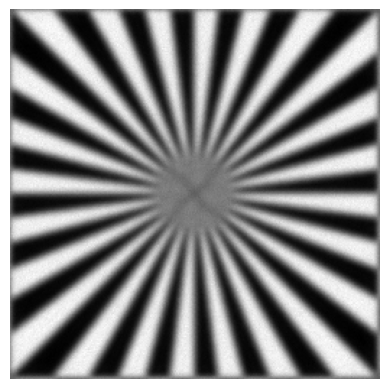

In [61]:
overlay_collect_image = np.zeros((height, width))
for i in range(collect_number):
    collect_image = collect_images[i, :, :]
    overlay_collect_image = overlay_collect_image + collect_image

plt.imshow(overlay_collect_image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()